In [1]:
import pickle
import sys
sys.path.insert(0,'../')

import baseline
import zipreg_model 
import zipgate_reg 
from inference import *
from criticism import *
from preprocess_bikeshare import *

In [2]:
with open('../data/demand_sample.pickle', 'rb') as f:
    data_samp = pickle.load(f)

In [3]:
train = data_samp.sample(frac=0.5, random_state=42)
test = data_samp.drop(train.index)


### Baseline

In [4]:
b_data, b_features = baseline.feature_generation(train)
b = baseline.PoissReg(b_features, b_data)

../baseline.py:68: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  with pyro.plate("data", len(data)):
Elbo loss: 830435.1875
Elbo loss: 190376.0
Elbo loss: 121470.1796875
Elbo loss: 83811.6171875
Elbo loss: 94884.4375
Elbo loss: 103634.546875
Elbo loss: 73266.8359375
Elbo loss: 68990.09375
Elbo loss: 66884.28125
Elbo loss: 64554.33984375


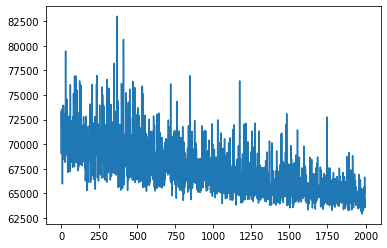

In [7]:
# Perform SVI
svi_baseline, elbo_loss = run_svi(b.model, b.guide,
                                 iters=5000,
                                 data=b_data['data'],
                                 demand=b_data['demand'],
                                 filename='../models/svi_baseline_params.pkl')

svi_posterior_baseline = get_svi_posterior(b_data['data'], b_data['demand'],
                                          svi=svi_baseline)

plot_elbo(elbo_loss[3000:])

In [5]:
# # Load parameters from inference
# svi_posterior_baseline = get_svi_posterior(b_data['data'], b_data['demand'],
#                                 model = b.model,
#                                   guide = b.guide,
#                                   filename='../models/svi_baseline_params.pkl')


In [9]:
post_samples_base = posterior_samples(
    b.wrapped_model,
    svi_posterior_baseline,
    b_data,
    ['obs','lmbda_post'],
    num_samples=1000)

Text(0.5, 1.0, 'Percent of observations with 0 demand')

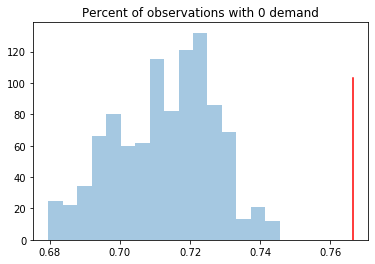

In [10]:
compare_test_statistic(test.demand.values, post_samples_base[:,0,:],
                       stat=perc_0)
plt.title('Percent of observations with 0 demand')

Text(0.5, 1.0, 'Max demand')

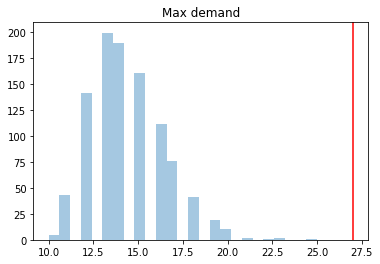

In [11]:
compare_test_statistic(test.demand.values, post_samples_base[:,0,:],
                       stat=max_)
plt.title('Max demand')

Text(0.5, 1.0, 'Avg demand')

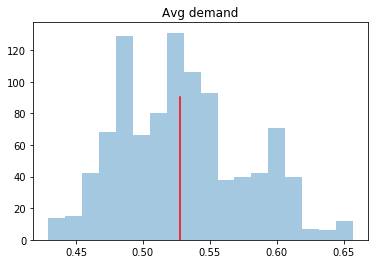

In [12]:
compare_test_statistic(test.demand.values, post_samples_base[:,0,:],
                       stat=mean)
plt.title('Avg demand')

### ZIP (shared gate parameter)

In [4]:
z_data, z_features = zipreg_model.feature_generation(train)
z = zipreg_model.ZIPoissReg(z_features, z_data)

../zipreg_model.py:94: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  gate_alpha_loc = pyro.param('gate_alpha_loc', torch.tensor(3.),
../zipreg_model.py:96: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  gate_beta_loc = pyro.param('gate_beta_loc', torch.tensor(3.),
../zipreg_model.py:122: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would b

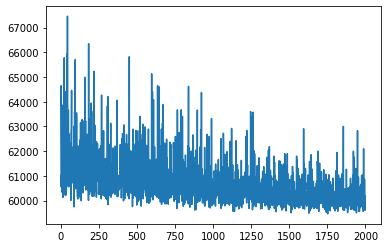

In [5]:
# Perform SVI
svi_zip, elbo_loss = run_svi(z.model, z.guide,
                                 iters=5000,
                                 data=z_data['data'],
                                 demand=z_data['demand'],
                                 filename='../models/svi_zip_params.pkl')

svi_posterior_zip = get_svi_posterior(z_data['data'], z_data['demand'],
                                          svi=svi_zip)

plot_elbo(elbo_loss[3000:])

In [16]:
# svi_posterior_zip = get_svi_posterior(z_data['data'], z_data['demand'],
#                                 model = z.model,
#                                   guide = z.guide,
#                                   filename='../models/svi_zip_params.pkl')

In [7]:
post_samples_zip = posterior_samples(
    z.wrapped_model,
    svi_posterior_zip,
    z_data,
    ['obs'],
    num_samples=1000)

In [9]:
svi_posterior_zip.information_criterion()

OrderedDict([('waic', tensor(123716.3906, grad_fn=<SumBackward0>)),
             ('p_waic', tensor(3341.0332, grad_fn=<SumBackward0>))])

Text(0.5, 1.0, 'Percent of observations with 0 demand')

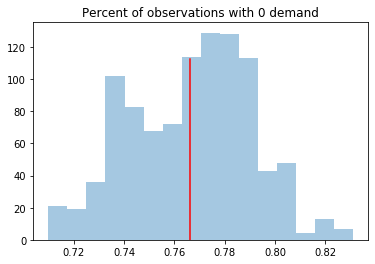

In [10]:
compare_test_statistic(test.demand.values, post_samples_zip[:,0,:],
                       stat=perc_0)
plt.title('Percent of observations with 0 demand')

Text(0.5, 1.0, 'Max demand')

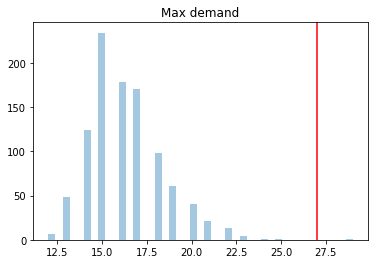

In [11]:
compare_test_statistic(test.demand.values, post_samples_zip[:,0,:],
                       stat=max_)
plt.title('Max demand')

Text(0.5, 1.0, 'Avg demand')

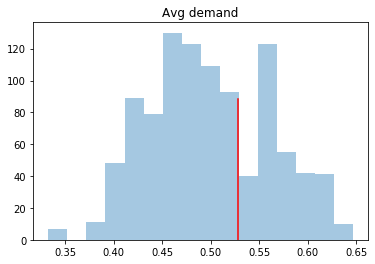

In [12]:
compare_test_statistic(test.demand.values, post_samples_zip[:,0,:],
                       stat=mean)
plt.title('Avg demand')

Text(0.5, 1.0, 'Percent of observations with 0 demand at station 70')

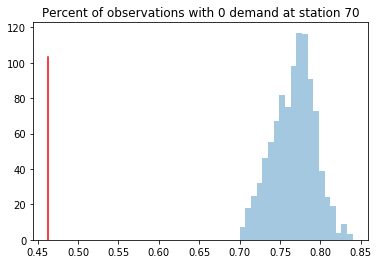

In [13]:
station_indx = (test.start_station_id==70)
compare_test_statistic(test[station_indx ].demand.values, post_samples_zip[:,:,station_indx.values ],
                       stat=perc_0)
plt.title('Percent of observations with 0 demand at station 70')

### ZIP (logit gate parameter)

In [23]:
zg_data, zg_features = zipgate_reg.feature_generation(train)
zg = zipgate_reg.ZIPoissRegGate(zg_features, zg_data)

/Users/Sam/.pyenv/versions/3.7.2/envs/probprog/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
../zipgate_reg.py:79: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  with pyro.plate("data", len(data)):
Elbo loss: 152514.46875
Elbo loss: 73497.109375
Elbo loss: 67053.9609375
Elbo loss: 62949.61328125
Elbo loss: 61656.0390625
Elbo loss: 59625.05078125
Elbo loss: 59743.79296875
Elbo loss: 59296.4765625
Elbo loss: 59349.703125
Elbo loss: 59295.6171875
/Users/Sam/.pyenv/versions/3.7.2/envs/probprog/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch

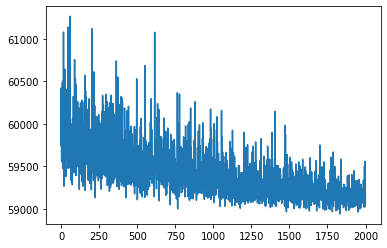

In [24]:
# Perform SVI
svi_zipgate, elbo_loss = run_svi(zg.model, zg.guide,
                                 iters=5000,
                                 data=zg_data['data'],
                                 demand=zg_data['demand'],
                                 filename='../models/svi_zip_params.pkl')

svi_posterior_zipgate = get_svi_posterior(zg_data['data'], zg_data['demand'],
                                          svi=svi_zipgate)

plot_elbo(elbo_loss[3000:])

In [19]:
# svi_posterior_zipgate = get_svi_posterior(zg_data['data'], zg_data['demand'],
#                                 model = zg.model,
#                                   guide = zg.guide,
#                                   filename='../models/svi_zipgate_params.pkl')

/Users/Sam/.pyenv/versions/3.7.2/envs/probprog/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [25]:
post_samples_zipgate = posterior_samples(
    zg.wrapped_model,
    svi_posterior_zipgate,
    zg_data,
    ['obs'],
    num_samples=1000)


In [26]:
svi_posterior_zipgate.information_criterion()


OrderedDict([('waic', tensor(118803.3750, grad_fn=<SumBackward0>)),
             ('p_waic', tensor(1130.8286, grad_fn=<SumBackward0>))])

Text(0.5, 1.0, 'Percent of observations with 0 demand')

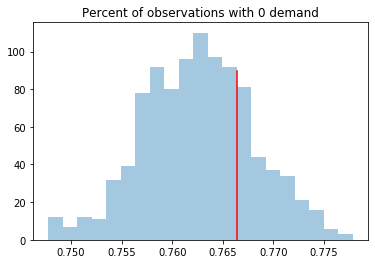

In [28]:
compare_test_statistic(test.demand.values, post_samples_zipgate,
                       stat=perc_0)
plt.title('Percent of observations with 0 demand')


Text(0.5, 1.0, 'Percent of observations with 0 demand at station 70 ')

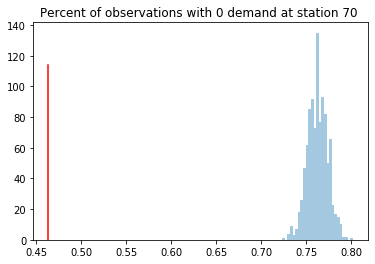

In [49]:
station_indx = ((test.start_station_id==70) )
compare_test_statistic(test[station_indx ].demand.values, post_samples_zipgate[:,:,station_indx.values ],
                       stat=perc_0)
plt.title('Percent of observations with 0 demand at station 70 ')


Text(0.5, 1.0, 'Max demand')

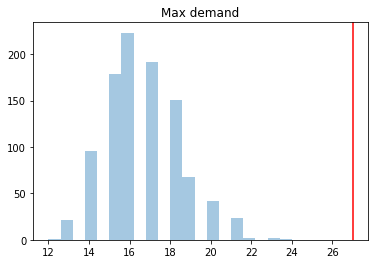

In [30]:
compare_test_statistic(test.demand.values, post_samples_zipgate,
                       stat=max_)
plt.title('Max demand')


Text(0.5, 1.0, 'Avg demand')

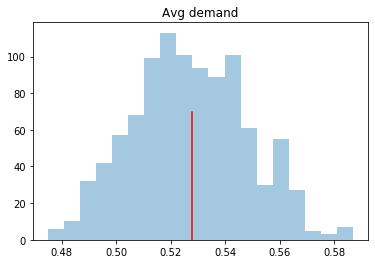

In [31]:
compare_test_statistic(test.demand.values, post_samples_zipgate,
                       stat=mean)
plt.title('Avg demand')
